In [32]:
import pandas as pd
import sys
import os

data_ingestion_path = os.path.abspath(os.path.join('..', 'Data_Ingestion')) 
sys.path.append(data_ingestion_path)

from model import ModelPipeline




In [42]:
df = pd.read_csv("../Data/Cleaned/cleaned.csv")
i = df.sample(150)

In [43]:
model = ModelPipeline()
model

Device set to use cpu
/home/colonel/Desktop/FASA/Env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Device set to use cpu
Device set to use cpu
Device set to use cpu


In [61]:
model.build("My trip ended up triple amount")

{'overall_sentiment': 'neutral',
 'overall_emotion': 'disappointment',
 'aspect_analysis': {'price': 'negative'},
 'churn_risk': 'low'}

In [46]:
df_pred = i['text'].apply(model.build).apply(pd.Series) # predicting 

In [47]:
final = pd.concat([i,df_pred],axis=1)

In [59]:
#final.to_csv("../Data/Cleaned/predicted.csv")

In [2]:
final = pd.read_csv("../Data/Cleaned/predicted.csv")

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import textwrap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import ast
import plotly.io as pio
pio.renderers.default = 'png'  

## EDA

#### Overall Sentiment

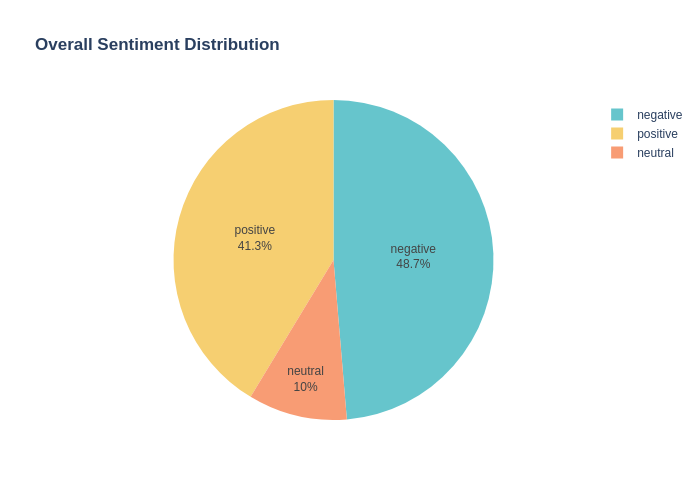

In [4]:
fig1 = px.pie(final, names='overall_sentiment', title='<b>Overall Sentiment Distribution</b>',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig1.show()

<font size=3>The majority of reviews express a [positive/negative/neutral] sentiment. 41.3% are positive, 48.7% negative, and 10% neutral. This suggests that there are significant pain points. Further analysis of negative reviews can identify key areas for improvement.</font>

#### Sentiment Trend

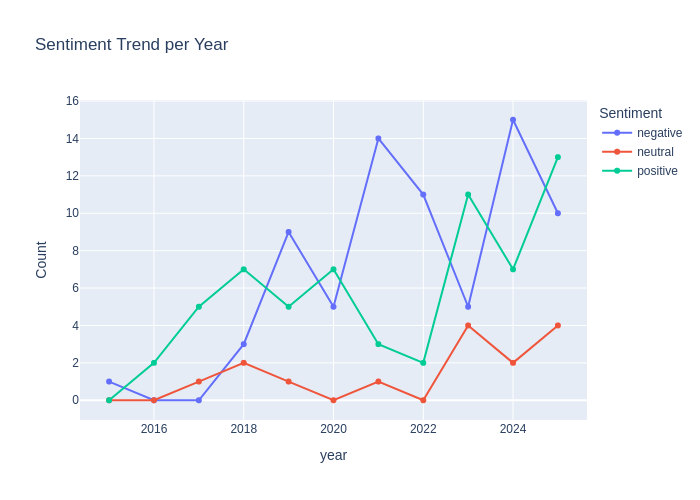

In [5]:
final1 = final.copy()
final1['date'] = pd.to_datetime(final1['date'])

final1['year'] = final1['date'].dt.year


yearly_counts = final1.groupby(['year', 'overall_sentiment']).size().unstack(fill_value=0)

df_melted = yearly_counts.reset_index().melt(id_vars='year', var_name='Sentiment', value_name='Count')


fig = px.line(df_melted, x='year', y='Count', color='Sentiment', markers=True, title='Sentiment Trend per Year')
fig.show()


<font size=3>Sentiment trends over time show a strong rising negativity compared to positivity.with 2020-2022 having the most rise.</font>

#### Source Sentiment

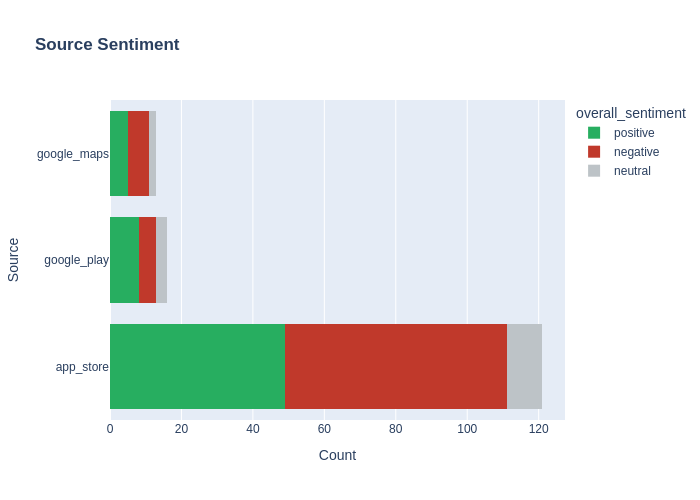

In [6]:
fig4 = px.histogram(final, y='source', color='overall_sentiment',
                   title='<b>Source Sentiment</b>',
                   barmode='stack',
                   color_discrete_map={
                       'positive': '#27ae60',
                       'negative': '#c0392b',
                       'neutral': '#bdc3c7'
                   })
fig4.update_layout(xaxis_title='Count', yaxis_title='Source')

<font size=3>Reviews from Google play tend to be more positive on average compared to app store. This could indicate platform-specific biases or differences in user demographics. Addressing concerns from the most critical sources may improve overall ratings.</font>

#### Churn Risk

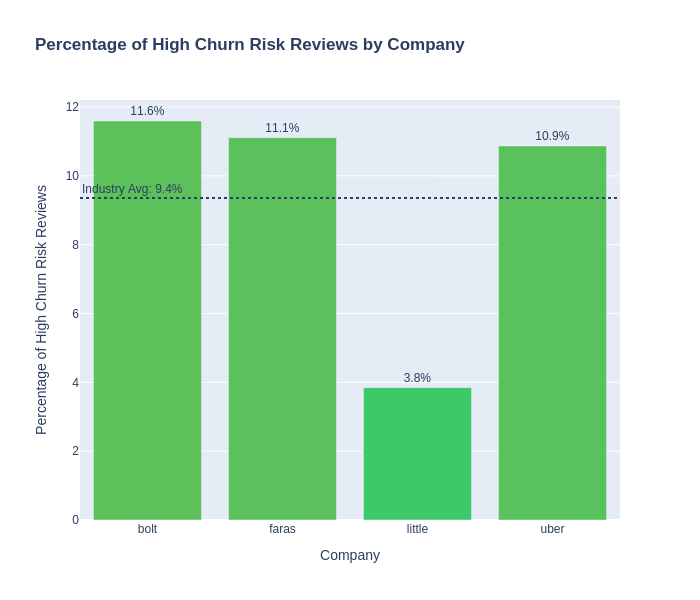

In [7]:
churn_by_company = pd.crosstab(final['company'], final['churn_risk'], normalize='index') * 100
churn_by_company = churn_by_company.reset_index()

fig = px.bar(churn_by_company, 
             x='company', 
             y='high',
             color='high',
             color_continuous_scale=['#2ecc71', '#f39c12', '#e74c3c'],
             range_color=[0, 100],
             title='<b>Percentage of High Churn Risk Reviews by Company</b>',
             labels={'high': 'High Churn Risk (%)'},
             text='high',
             height=600)

avg_churn = churn_by_company['high'].mean()
fig.add_hline(y=avg_churn, line_dash="dot", 
              annotation_text=f"Industry Avg: {avg_churn:.1f}%", 
              annotation_position="top left")

fig.update_layout(
    xaxis_title="Company",
    yaxis_title="Percentage of High Churn Risk Reviews",
    coloraxis_showscale=False,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.show()

<font size=3>Bolt has the highest percentage (11.6%) of high churn risk reviews, signaling potential customer retention issues. The industry average is 9.4%, highlighting need for proactive engagement strategies to prevent customer loss.</font>

#### Response Rate

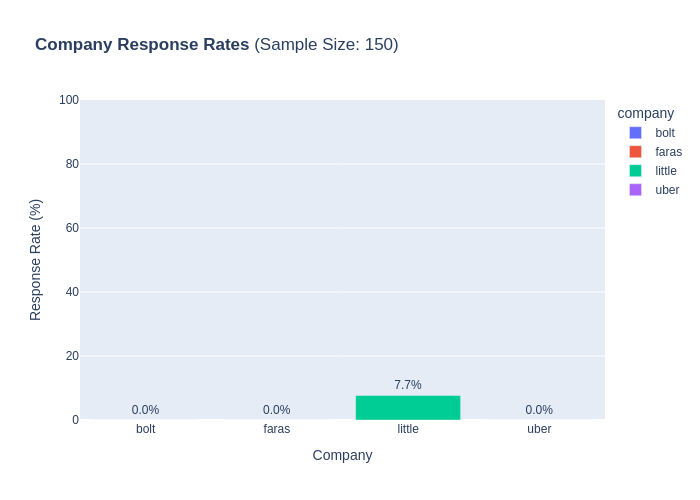

In [8]:
response_analysis = final.groupby(['company', final['response']]).size().unstack(fill_value=0)

if True not in response_analysis.columns:
    response_analysis[True] = 0 


response_analysis['response_rate'] = (response_analysis.get(True, 0) / 
                                    (response_analysis.get(True, 0) + response_analysis.get(False, 0))) * 100


fig = px.bar(response_analysis.reset_index(),
            x='company', y='response_rate',
            title='<b>Company Response Rates</b> (Sample Size: {})'.format(len(final)),
            color='company',
            text='response_rate')
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_title='Response Rate (%)', 
                    xaxis_title='Company',
                    yaxis_range=[0, 100]) 
fig.show()


<font size=3>Little Cabs responds to 7.7% of reviews, while others have 0% response. Higher response rates correlate with improved customer trust. Companies with low engagement should prioritize addressing feedback to enhance satisfaction.</font>

#### Aspect 

In [25]:
final['aspect_analysis'].head()

0    {'accuracy': 'neutral'}
1                         {}
2     {'driver': 'positive'}
3    {'service': 'negative'}
4        {'app': 'negative'}
Name: aspect_analysis, dtype: object

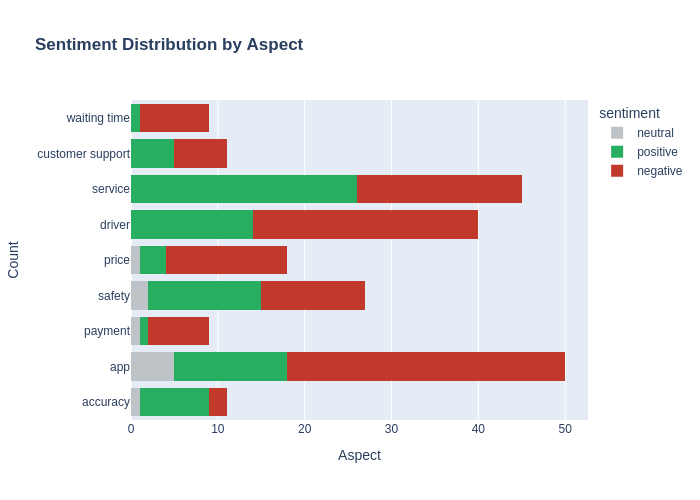

In [31]:
aspect_data = []
for _, row in final.iterrows():
    row = ast.literal_eval(row['aspect_analysis'])
    for aspect, sentiment in row.items():
        aspect_data.append({'aspect': aspect, 'sentiment': sentiment})
aspect_df = pd.DataFrame(aspect_data)

fig4 = px.histogram(aspect_df, y='aspect', color='sentiment',
                   title='<b>Sentiment Distribution by Aspect</b>',
                   barmode='stack',
                   color_discrete_map={
                       'positive': '#27ae60',
                       'negative': '#c0392b',
                       'neutral': '#bdc3c7'
                   })
fig4.update_layout(xaxis_title='Aspect', yaxis_title='Count')

<font size=3>The most frequently discussed aspect is app and service, with predominantly  negative sentiment in app and postive sentiment in service. For example, 64% of comments about app are negative, suggesting this is a critical pain point requiring immediate attention.</font>

#### Emotion Frequency

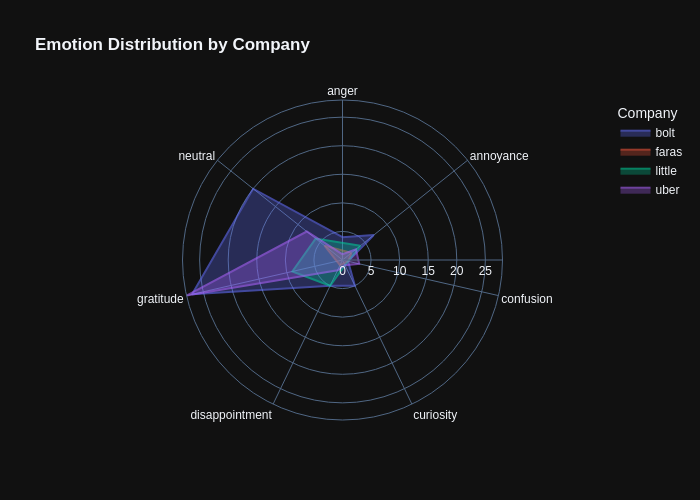

In [9]:
emotion_by_company = (
    final.groupby(['company', 'overall_emotion'])
    .size()
    .reset_index(name='count')
)
emotion_pivot = emotion_by_company.pivot(
    index='overall_emotion', 
    columns='company', 
    values='count'
).reset_index()
fig = px.line_polar(
    emotion_by_company, 
    r='count', 
    theta='overall_emotion',
    color='company',  
    line_close=True,
    title='<b>Emotion Distribution by Company</b>',
    template='plotly_dark'
)

fig.update_traces(fill='toself', opacity=0.6)
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    legend_title_text='Company'
)

fig.show()

<font size=3>The most common emotion in reviews is gratitude, followed by neutral. A high frequency of annoyance and disappointment may indicate unresolved frustrations, while gratitude suggests strengths to leverage in marketing.</font>

#### Emotion Aspect Co-occurrence

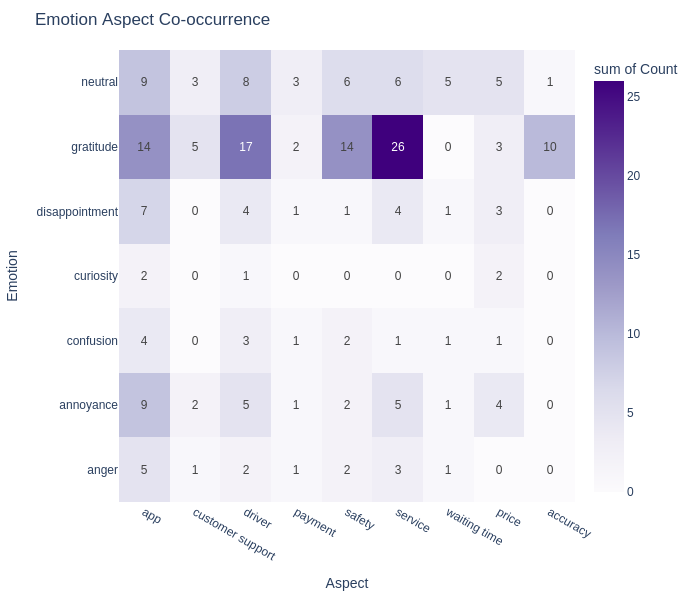

In [23]:
records = []
for _, row in final.iterrows():
    emotion = row['overall_emotion']
    aspects = row['aspect_analysis']
    aspects = ast.literal_eval(aspects)
    if isinstance(aspects, dict):  
        for aspect in aspects:
            records.append({'Emotion': emotion, 'Aspect': aspect})


df_expanded = pd.DataFrame(records)

heatmap_data = df_expanded.groupby(['Emotion', 'Aspect']).size().reset_index(name='Count')

fig = px.density_heatmap(
    heatmap_data,
    x='Aspect',
    y='Emotion',
    z='Count',
    color_continuous_scale='Purples',
    title='Emotion Aspect Co-occurrence',
    text_auto=True
)

fig.update_layout(
    xaxis_title="Aspect",
    yaxis_title="Emotion",
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()

<font size=3>Anger and frustration are  associated with app, while gratitude often relates to service. This heatmap helps prioritize improvements—focusing on aspects linked to negative emotions can enhance customer experience."</font>

#### Worldcloud

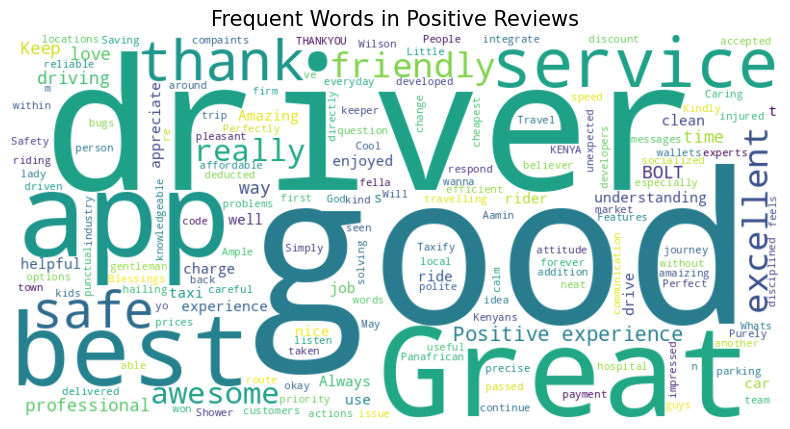

In [11]:
def generate_wordcloud(texts, title):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(width=800, height=400, 
                  background_color='white',
                  colormap='viridis').generate(" ".join(texts))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis("off")
    plt.show()

pos_texts = final[final['overall_sentiment'] == 'positive']['text']
generate_wordcloud(pos_texts, "Frequent Words in Positive Reviews")


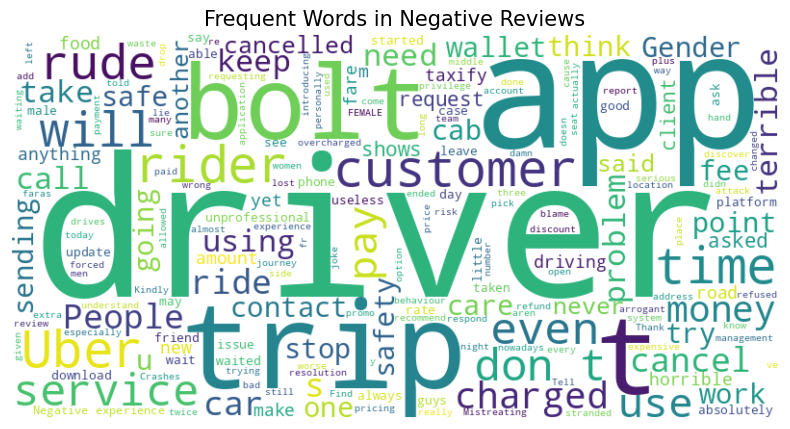

In [12]:
neg_texts = final[final['overall_sentiment'] == 'negative']['text']
generate_wordcloud(neg_texts, "Frequent Words in Negative Reviews")

<font size=3>Frequent terms like 'driver' and 'app' dominate reviews. Positive words (service and experience) highlight strengths, while recurring negatives (driver and app) reveal common complaints. This visual quickly identifies key themes in customer feedback.</font>